In [1]:
import gym
import tensorflow as tf
import numpy as np

/home/gopi/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
env = gym.make("CartPole-v0")

We interact with the simulation through env. To show the simulation running, you can use env.render() to render one frame. Passing in an action as an integer to env.step will generate the next step in the simulation. You can see how many actions are possible from env.action_space and to get a random action you can use env.action_space.sample(). This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

In [3]:
env.reset()
rewards = []
# env.step(env.action_space.sample())
for _ in range(100):
    env.render()
    state, reward, done , info = env.step(env.action_space.sample())
    rewards.append(reward)
    if done:
#         print(rewards[:10])
        rewards = []
        env.reset()
        

In [4]:
rewards

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [5]:
env.close()

In [6]:
state

array([ 0.07974487,  0.17801903, -0.07881684, -0.37991832])

In [7]:
env.action_space

Discrete(2)

## Q-Network
We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$
where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-table. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>

As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$.

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [8]:
class QNetwork:
    def __init__(self , learning_rate=0.01,
                state_size=4, 
                action_size=2,
                hidden_size=10,
                name='QNetwork'):
        # state inputs to the Q-Network
        # https://stackoverflow.com/questions/35919020/whats-the-difference-of-name-scope-and-a-variable-scope-in-tensorflow
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
        
            # One hot encode the actions to latte choose the Q-Value for the action
            self.actions_ = tf.placeholder(tf.int32 , [None] , name="actions") # action value is 0 or 1 , one_hot take int values
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None] , name="targetQ")
            
            # ReLU hidden layer
            # See tf.layers.dense() tf.contrib.layers.fully_connected()
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_ , hidden_size) # activation relu applied by default 
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1 , hidden_size)
            
            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2 , action_size , activation_fn=None)
            
            
            ## Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output , one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            
            

## Experience replay
Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on.

Here, we'll create a Memory object that will store our experiences, our transitions $ < s, a, r, s' > $. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $< s, a, r, s' >$ and train on those.

Below, I've implemented a Memory object. If you're unfamiliar with deque, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [9]:
from collections import deque
class Memory():
    def __init__(self , max_size= 1000):
        self.buffer = deque(maxlen = max_size)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        index = np.random.choice(np.arange(len(self.buffer)),
                                size = batch_size,
                                replace = False)
        return [self.buffer[idx] for idx in index]

## Exploration - Exploitation
To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon). That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an $\epsilon$-greedy policy.

At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called exploitation. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm
Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in episodes. One episode is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

Initialize the memory $D$

Initialize the action-value network $Q$ with random weights

For episode = 1, $M$ do

For $t$, $T$ do

With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$

Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$

Store transition $ < s_t, a_t, r_{t+1}, s_{t+1} > $ in memory $D$

Sample random mini-batch from $D$: 
$< s_j, a_j, r_j, s'_j >$

Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$

Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$

endfor

endfor

In [10]:
train_episodes = 700          # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.99                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [11]:
tf.reset_default_graph()
mainQN = QNetwork(name="main" , hidden_size=hidden_size, learning_rate=learning_rate)

### Populate the experience memory
Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [12]:
env.reset()

# Take one random step to get the pole and cart moving
state , reward, done, info = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for i in range(pretrain_length):
    #env.render()
    
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    
    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    
    else:
        # Add experience to memory
        memory.add((state,action, reward , next_state))
        state = next_state

### Training
Below we'll train our agent. If you want to watch it train, uncomment the env.render() line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [13]:
# Now train with experience

saver = tf.train.Saver()
rewards_list = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    decay_step = 0
    for episode in range(1, train_episodes):
        total_reward = 0
        step =0
        while step < max_steps:
            decay_step +=1
            env.render()
            
            # Explore or Exploit
            explore_prob = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*decay_step)
            
            if explore_prob > np.random.rand() : # return [0,1)
                # random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_:state.reshape((1, *state.shape))}
                Q_pred = sess.run(mainQN.output , feed_dict= feed)
                action = np.argmax(Q_pred)
                
            # Take action, get new_state and reward
            next_state , reward , done, _ = env.step(action)
            
            total_reward +=reward
            
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                step = max_steps
                
                print('Episode: {}'.format(episode),
                     'Total reward: {}'.format(total_reward),
                     'Training loss: {:.4f}'.format(loss),
                     'Explore Prob: {:.4f}'.format(explore_prob))
                
                rewards_list.append((episode , total_reward))
                
                # Add experience to memory
                memory.add((state, action,reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
                
            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                step +=1
                
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states_mb = np.array([each[0] for each in batch])
            actions_mb = np.array([each[1] for each in batch])
            rewards_mb = np.array([each[2] for each in batch])
            next_states_mb = np.array([each[3] for each in batch])
            
            ### TRAINING NETWORK
            targetQs = sess.run(mainQN.output, feed_dict={mainQN.inputs_:next_states_mb})
            
            # Set target_Qs to 0 for states where episode ends 
            episode_ends = (next_states_mb==np.zeros(states_mb[0].shape)).all(axis=1)
            
            targetQs[episode_ends]  = (0,0)
            
            targets = rewards_mb + gamma*np.max(targetQs, axis=1)
            
            loss , _ = sess.run([mainQN.loss , mainQN.optimizer],
                               feed_dict={mainQN.inputs_:states_mb,
                                         mainQN.targetQs_: targets,
                                         mainQN.actions_: actions_mb})
            
            
    
    saver.save(sess, "checkpoints/cartpole{}.ckpt".format(train_episodes))

Episode: 1 Total reward: 9.0 Training loss: 1.0676 Explore Prob: 0.9991
Episode: 2 Total reward: 34.0 Training loss: 1.0862 Explore Prob: 0.9958
Episode: 3 Total reward: 20.0 Training loss: 1.0174 Explore Prob: 0.9938
Episode: 4 Total reward: 11.0 Training loss: 1.0658 Explore Prob: 0.9927
Episode: 5 Total reward: 13.0 Training loss: 1.0433 Explore Prob: 0.9914
Episode: 6 Total reward: 11.0 Training loss: 0.9909 Explore Prob: 0.9903
Episode: 7 Total reward: 18.0 Training loss: 1.0400 Explore Prob: 0.9886
Episode: 8 Total reward: 14.0 Training loss: 1.1450 Explore Prob: 0.9872
Episode: 9 Total reward: 25.0 Training loss: 1.0098 Explore Prob: 0.9848
Episode: 10 Total reward: 23.0 Training loss: 1.0010 Explore Prob: 0.9825
Episode: 11 Total reward: 12.0 Training loss: 1.0564 Explore Prob: 0.9814
Episode: 12 Total reward: 16.0 Training loss: 1.1569 Explore Prob: 0.9798
Episode: 13 Total reward: 26.0 Training loss: 1.2595 Explore Prob: 0.9773
Episode: 14 Total reward: 30.0 Training loss: 1.

Episode: 111 Total reward: 24.0 Training loss: 145.3499 Explore Prob: 0.8078
Episode: 112 Total reward: 9.0 Training loss: 1025.8918 Explore Prob: 0.8071
Episode: 113 Total reward: 35.0 Training loss: 198.8607 Explore Prob: 0.8043
Episode: 114 Total reward: 17.0 Training loss: 100.9967 Explore Prob: 0.8030
Episode: 115 Total reward: 8.0 Training loss: 369.5026 Explore Prob: 0.8024
Episode: 116 Total reward: 24.0 Training loss: 540.6777 Explore Prob: 0.8005
Episode: 117 Total reward: 13.0 Training loss: 1565.1658 Explore Prob: 0.7994
Episode: 118 Total reward: 18.0 Training loss: 232.9364 Explore Prob: 0.7980
Episode: 119 Total reward: 16.0 Training loss: 784.3796 Explore Prob: 0.7967
Episode: 120 Total reward: 30.0 Training loss: 118.9949 Explore Prob: 0.7944
Episode: 121 Total reward: 23.0 Training loss: 1015.5011 Explore Prob: 0.7926
Episode: 122 Total reward: 14.0 Training loss: 953.0809 Explore Prob: 0.7915
Episode: 123 Total reward: 16.0 Training loss: 98.2815 Explore Prob: 0.7902

Episode: 218 Total reward: 15.0 Training loss: 16.6577 Explore Prob: 0.6665
Episode: 219 Total reward: 11.0 Training loss: 536.8705 Explore Prob: 0.6658
Episode: 220 Total reward: 11.0 Training loss: 557.0724 Explore Prob: 0.6650
Episode: 221 Total reward: 15.0 Training loss: 2003.0137 Explore Prob: 0.6641
Episode: 222 Total reward: 13.0 Training loss: 526.4497 Explore Prob: 0.6632
Episode: 223 Total reward: 9.0 Training loss: 1348.9749 Explore Prob: 0.6626
Episode: 224 Total reward: 14.0 Training loss: 1717.6517 Explore Prob: 0.6617
Episode: 225 Total reward: 12.0 Training loss: 14.3408 Explore Prob: 0.6609
Episode: 226 Total reward: 19.0 Training loss: 1499.5066 Explore Prob: 0.6597
Episode: 227 Total reward: 13.0 Training loss: 1866.4984 Explore Prob: 0.6589
Episode: 228 Total reward: 10.0 Training loss: 1010.0218 Explore Prob: 0.6582
Episode: 229 Total reward: 14.0 Training loss: 568.6185 Explore Prob: 0.6573
Episode: 230 Total reward: 19.0 Training loss: 907.2394 Explore Prob: 0.6

Episode: 326 Total reward: 15.0 Training loss: 8.9749 Explore Prob: 0.5763
Episode: 327 Total reward: 12.0 Training loss: 10.8010 Explore Prob: 0.5757
Episode: 328 Total reward: 21.0 Training loss: 506.7152 Explore Prob: 0.5745
Episode: 329 Total reward: 23.0 Training loss: 257.4139 Explore Prob: 0.5732
Episode: 330 Total reward: 8.0 Training loss: 779.2489 Explore Prob: 0.5727
Episode: 331 Total reward: 17.0 Training loss: 114.0925 Explore Prob: 0.5718
Episode: 332 Total reward: 9.0 Training loss: 640.8348 Explore Prob: 0.5713
Episode: 333 Total reward: 8.0 Training loss: 10.8398 Explore Prob: 0.5708
Episode: 334 Total reward: 15.0 Training loss: 5.9899 Explore Prob: 0.5700
Episode: 335 Total reward: 9.0 Training loss: 9.5992 Explore Prob: 0.5695
Episode: 336 Total reward: 27.0 Training loss: 352.8935 Explore Prob: 0.5680
Episode: 337 Total reward: 19.0 Training loss: 325.7574 Explore Prob: 0.5669
Episode: 338 Total reward: 17.0 Training loss: 1089.9818 Explore Prob: 0.5660
Episode: 3

Episode: 434 Total reward: 10.0 Training loss: 2.7699 Explore Prob: 0.4957
Episode: 435 Total reward: 12.0 Training loss: 266.0764 Explore Prob: 0.4951
Episode: 436 Total reward: 7.0 Training loss: 7.5234 Explore Prob: 0.4948
Episode: 437 Total reward: 17.0 Training loss: 65.9069 Explore Prob: 0.4940
Episode: 438 Total reward: 22.0 Training loss: 310.5612 Explore Prob: 0.4929
Episode: 439 Total reward: 12.0 Training loss: 52.6312 Explore Prob: 0.4923
Episode: 440 Total reward: 11.0 Training loss: 120.1447 Explore Prob: 0.4918
Episode: 441 Total reward: 14.0 Training loss: 167.7856 Explore Prob: 0.4911
Episode: 442 Total reward: 19.0 Training loss: 2.6016 Explore Prob: 0.4902
Episode: 443 Total reward: 15.0 Training loss: 179.0249 Explore Prob: 0.4895
Episode: 444 Total reward: 17.0 Training loss: 35.5256 Explore Prob: 0.4887
Episode: 445 Total reward: 14.0 Training loss: 2.9116 Explore Prob: 0.4880
Episode: 446 Total reward: 18.0 Training loss: 112.0266 Explore Prob: 0.4871
Episode: 44

Episode: 542 Total reward: 117.0 Training loss: 23.7003 Explore Prob: 0.3611
Episode: 543 Total reward: 28.0 Training loss: 40.8575 Explore Prob: 0.3602
Episode: 544 Total reward: 76.0 Training loss: 2.9313 Explore Prob: 0.3575
Episode: 545 Total reward: 101.0 Training loss: 7.9095 Explore Prob: 0.3540
Episode: 546 Total reward: 113.0 Training loss: 13.8029 Explore Prob: 0.3502
Episode: 547 Total reward: 66.0 Training loss: 3.0996 Explore Prob: 0.3479
Episode: 548 Total reward: 67.0 Training loss: 3.2105 Explore Prob: 0.3457
Episode: 549 Total reward: 40.0 Training loss: 13.0362 Explore Prob: 0.3443
Episode: 550 Total reward: 61.0 Training loss: 47.1425 Explore Prob: 0.3423
Episode: 551 Total reward: 53.0 Training loss: 34.4108 Explore Prob: 0.3405
Episode: 552 Total reward: 88.0 Training loss: 33.9380 Explore Prob: 0.3376
Episode: 553 Total reward: 113.0 Training loss: 2.7340 Explore Prob: 0.3340
Episode: 554 Total reward: 96.0 Training loss: 99.0168 Explore Prob: 0.3309
Episode: 555 

Episode: 650 Total reward: 199.0 Training loss: 1.8125 Explore Prob: 0.1412
Episode: 651 Total reward: 87.0 Training loss: 1.5656 Explore Prob: 0.1401
Episode: 652 Total reward: 199.0 Training loss: 1.0751 Explore Prob: 0.1375
Episode: 653 Total reward: 199.0 Training loss: 0.3895 Explore Prob: 0.1350
Episode: 654 Total reward: 199.0 Training loss: 0.8086 Explore Prob: 0.1325
Episode: 655 Total reward: 147.0 Training loss: 0.9241 Explore Prob: 0.1307
Episode: 656 Total reward: 159.0 Training loss: 1.6602 Explore Prob: 0.1288
Episode: 657 Total reward: 199.0 Training loss: 2.1363 Explore Prob: 0.1265
Episode: 658 Total reward: 199.0 Training loss: 0.7451 Explore Prob: 0.1242
Episode: 659 Total reward: 199.0 Training loss: 0.5161 Explore Prob: 0.1220
Episode: 660 Total reward: 187.0 Training loss: 0.8356 Explore Prob: 0.1199
Episode: 661 Total reward: 199.0 Training loss: 1.2196 Explore Prob: 0.1177
Episode: 662 Total reward: 199.0 Training loss: 0.8289 Explore Prob: 0.1156
Episode: 663 

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N

Text(0,0.5,'Total Reward')

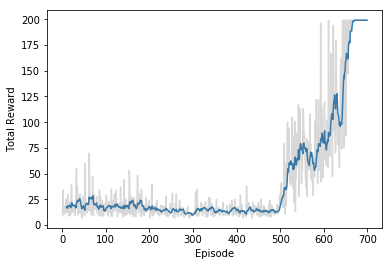

In [15]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

In [16]:
test_episodes = 10
test_max_steps = 400
env.reset()
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    for ep in range(1, test_episodes):
        t = 0
        while t < test_max_steps:
            env.render() 
            
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            
            if done:
                t = test_max_steps
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())
#                 print('Episode: {}'.format(ep),
#                      'Total reward: {}'.format(total_reward),
#                      'Training loss: {:.4f}'.format(loss),
#                      'Explore Prob: {:.4f}'.format(explore_prob))
                

            else:
                state = next_state
                t += 1

INFO:tensorflow:Restoring parameters from checkpoints/cartpole700.ckpt


In [118]:
env.close()